In [70]:
import scipy.stats as st
import torch
import autograd.numpy as np
from autograd import grad
from torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

In [71]:
import torch
import torch.distributions as dist

def hamiltonian_monte_carlo(n_samples, negative_log_prob_new, initial_position, path_len, step_size):
    # random step size
    if step_size is None:
        step_size = torch.tensor(0.01 + (0.05 - 0.01) * torch.rand(1))

    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = dist.MultivariateNormal(torch.zeros(initial_position.shape), torch.eye(initial_position.shape[0]))

    # If initial_position is a 2D tensor and n_samples is 100, we want
    # 100 x 2 momentum draws; do one momentum.sample call
    size = (n_samples,) + initial_position.shape[:1]
    print(size)
    count = 0  # to keep track of how many samples we've drawn
    for _ in range(size[0]):
        p0 = momentum.sample() # initial momentum draw
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog( 
            samples[-1],
            p0,
            negative_log_prob_new,
            initial_position,
            path_len=path_len,
            step_size=step_size,
        )
        # Do Metropolis accept/reject step
        start_log_p = negative_log_prob_new(samples[-1]) - torch.sum(momentum.log_prob(p0)) 
        new_log_p = negative_log_prob_new(q_new) - torch.sum(momentum.log_prob(p_new)) 
        if torch.log(torch.rand(size=(1,))) < start_log_p - new_log_p: # log probability difference
            samples.append(q_new) # accept
            count += 1 # for computing accept rate
        else:
            samples.append(samples[-1].clone()) # reject

    return torch.stack(samples[1:], dim=0), count 

def leapfrog(q, p, negative_log_prob_new, initial_position, path_len, step_size): # do one leapfrog step
    q, p = q.clone(), p.clone() # copy to avoid mutation

    # Compute the gradient of the negative log probability
    dVdq = torch.autograd.grad(negative_log_prob_new(initial_position), initial_position, create_graph=False)[0]
    p -= step_size * dVdq / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        dVdq = torch.autograd.grad(negative_log_prob_new(q), q, create_graph=False)[0]  # Recompute gradient
        p -= step_size * dVdq  # whole step
    q += step_size * p  # whole step
    dVdq = torch.autograd.grad(negative_log_prob_new(q), q, create_graph=False)[0]  # Recompute gradient
    p -= step_size * dVdq / 2  # half step
    # Momentum flip at end 
    return q, -p

# Define negative log probability function to sample from
def negative_log_prob_new(x):

    # Define the means and covariance matrices of the two normal distributions
    mu_1 = torch.zeros(2)
    mu_2 = torch.tensor([2.0, 2.0])
    cov_1 = torch.eye(2)
    cov_2 = torch.tensor([[0.3*0.3, 0.3*0.3*0.8], [0.3*0.8*0.3, 0.3*0.3]])

    # Create the two normal distributions
    phi_1 = dist.MultivariateNormal(mu_1, cov_1).log_prob(x).exp()
    phi_2 = dist.MultivariateNormal(mu_2, cov_2).log_prob(x).exp()

    # Compute the log probability of a sample
    prob = (2/3) * phi_1 + (1/3) * phi_2
    return -prob.log() # negative log probability

### Run the HMC algorithm

n_samples = 10000
initial_position = torch.tensor([0.0, 0.0], requires_grad=True)
burn_in = 1000

samples, count = hamiltonian_monte_carlo(n_samples, negative_log_prob_new, initial_position, path_len=10, step_size=0.1)
samples = samples[burn_in:]
avg_acceptance_rate = count / n_samples

print("Average acceptance rate:", avg_acceptance_rate)


(10000, 2)
Average acceptance rate: 0.9134


## 1. Samples plot

Text(0.5, 1.0, 'Hamiltonian Monte Carlo samples of x and y')

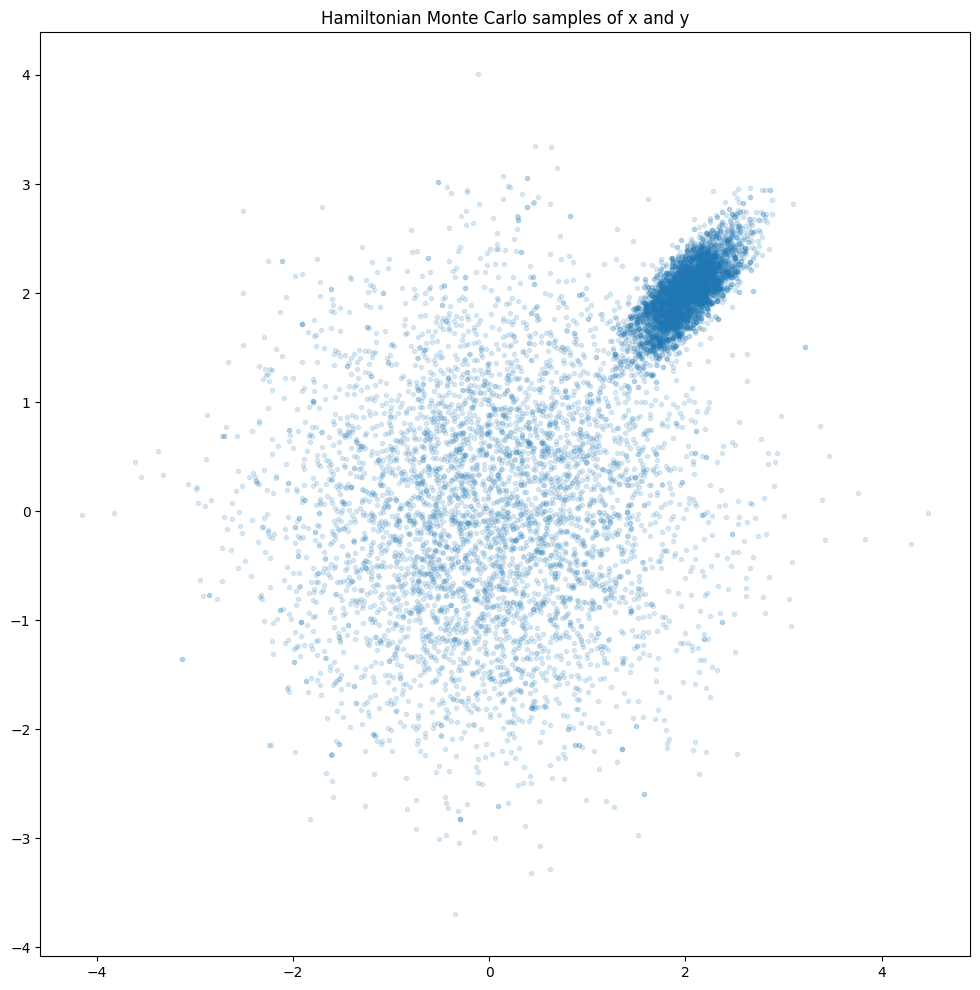

In [73]:
plt.figure(figsize=(12,12))
plt.plot(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), linestyle='', marker='o', markersize=3, alpha=0.15)
plt.title("Hamiltonian Monte Carlo samples of x and y")

## 2. Autocorrelation plots

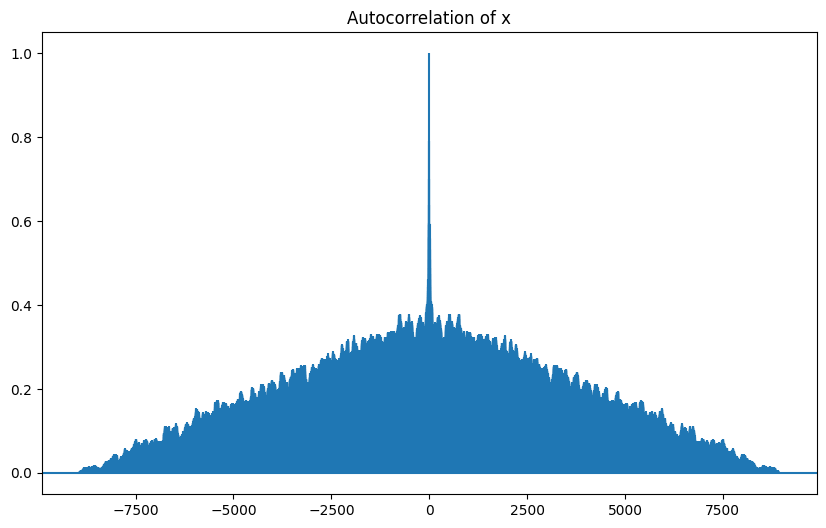

In [74]:
plt.figure(figsize=(10, 6))
plt.acorr(samples[:, 0].detach().numpy(), maxlags=None)
# plt.xlim([0,10000] )
plt.figsize=(20,50)
plt.title("Autocorrelation of x")
plt.show()

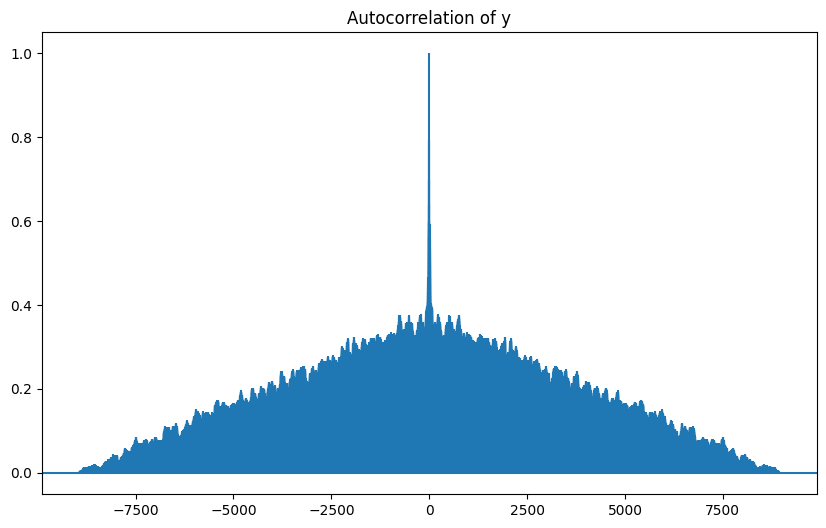

In [75]:
plt.figure(figsize=(10, 6))
plt.acorr(samples[:, 1].detach().numpy(), maxlags=None)
# plt.xlim([0,10000] )
plt.figsize=(20,50)
plt.title("Autocorrelation of y")
plt.show()

## 3. Trace plots

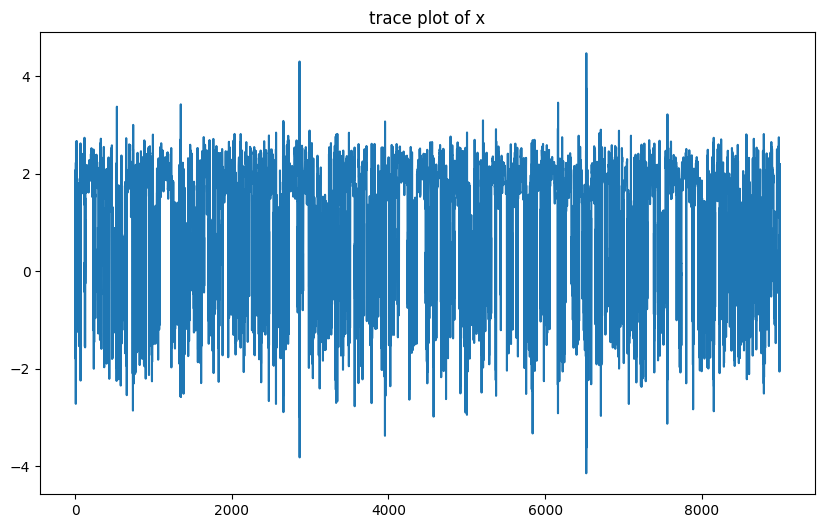

In [76]:
plt.figure(figsize=(10, 6))
plt.plot( np.arange(samples.shape[0]) ,samples[:, 0].detach().numpy())
plt.title("trace plot of x")
plt.show()

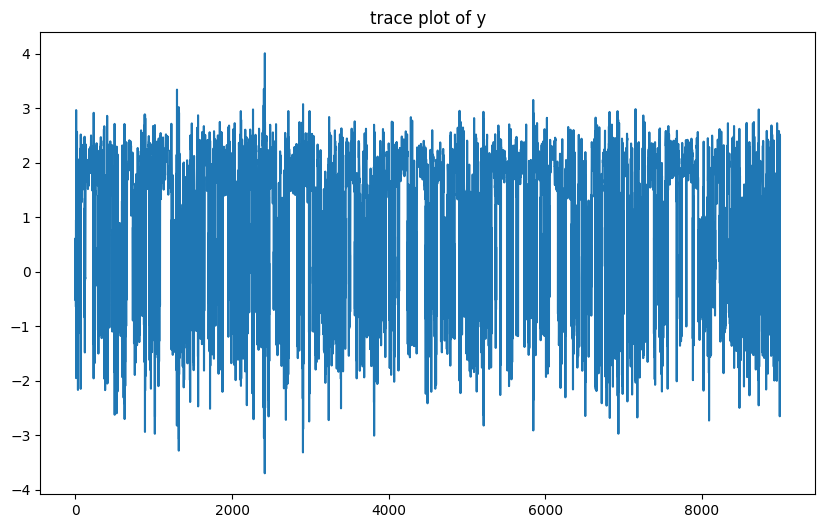

In [77]:
plt.figure(figsize=(10, 6))
plt.plot( np.arange(samples.shape[0]) ,samples[:, 1].detach().numpy())
plt.title("trace plot of y")
plt.show()

## 4. Moving average of mean

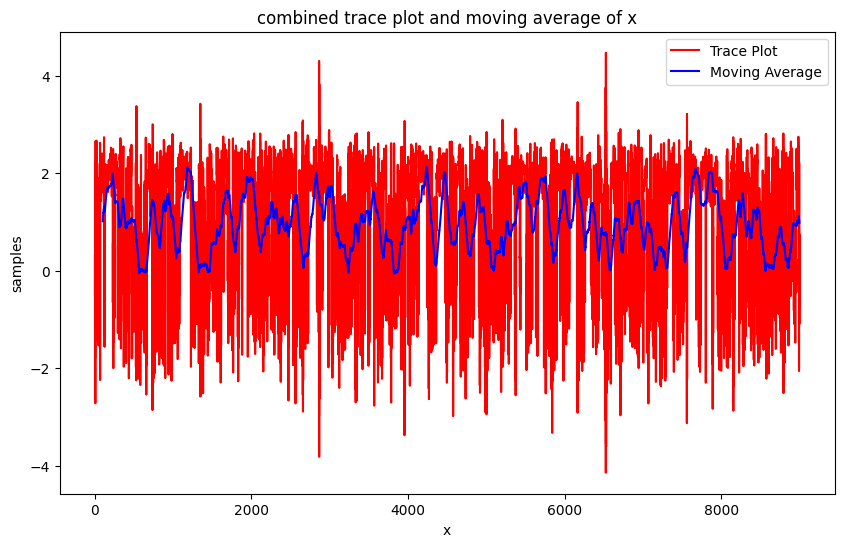

In [78]:
window_size = 100

# Calculate the moving average
moving_average = np.convolve(samples[:,0].detach().numpy(), np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(samples[:,0].detach().numpy(), label='Trace Plot', color='red')
plt.plot(range(window_size-1, len(samples[:,0].detach().numpy())), moving_average, label='Moving Average', color='blue')
plt.title('combined trace plot and moving average of x')
plt.xlabel('x')
plt.ylabel('samples')
plt.legend()
plt.show()

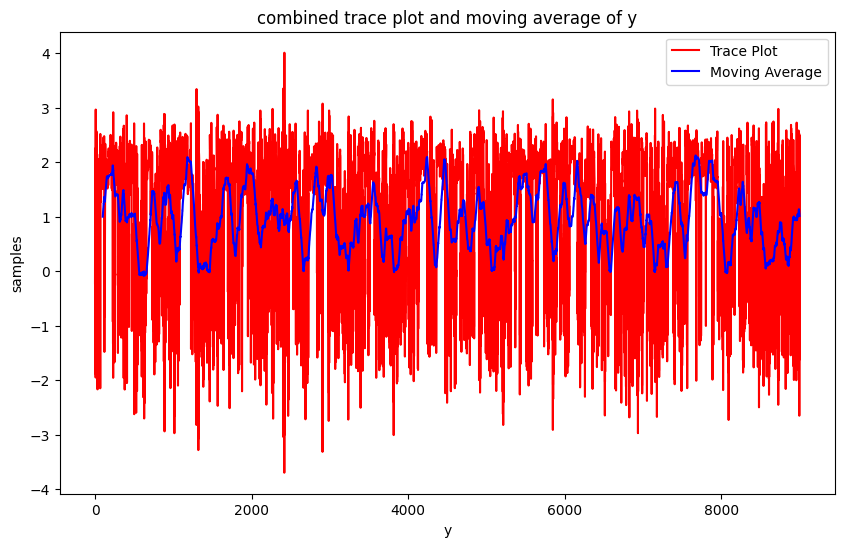

In [79]:
window_size = 100

# Calculate the moving average
moving_average = np.convolve(samples[:,1].detach().numpy(), np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(samples[:,1].detach().numpy(), label='Trace Plot', color='red')
plt.plot(range(window_size-1, len(samples[:,1].detach().numpy())), moving_average, label='Moving Average', color='blue')
plt.title('combined trace plot and moving average of y')
plt.xlabel('y')
plt.ylabel('samples')
plt.legend()
plt.show()

## 5. Gelman-Rubin
Run the chain more than one time (running it twice here)

In [80]:
n_samples_new = 5000
samples_1, count_1 = hamiltonian_monte_carlo(n_samples_new, negative_log_prob_new, initial_position, path_len=10, step_size=0.1)
samples_1 = samples[burn_in:]
avg_acceptance_rate_1 = count_1 / n_samples_new

print("Average acceptance rate:", avg_acceptance_rate_1)

samples_2, count_2 = hamiltonian_monte_carlo(n_samples_new, negative_log_prob_new, initial_position, path_len=10, step_size=0.1)
samples_2 = samples[burn_in:]
avg_acceptance_rate_2 = count_2 / n_samples_new

print("Average acceptance rate:", avg_acceptance_rate_2)

(5000, 2)
Average acceptance rate: 0.9358
(5000, 2)
Average acceptance rate: 0.9302


### plot the trace plots of both chains

Text(0.5, 1.0, 'chain 2 - trace plot of y ')

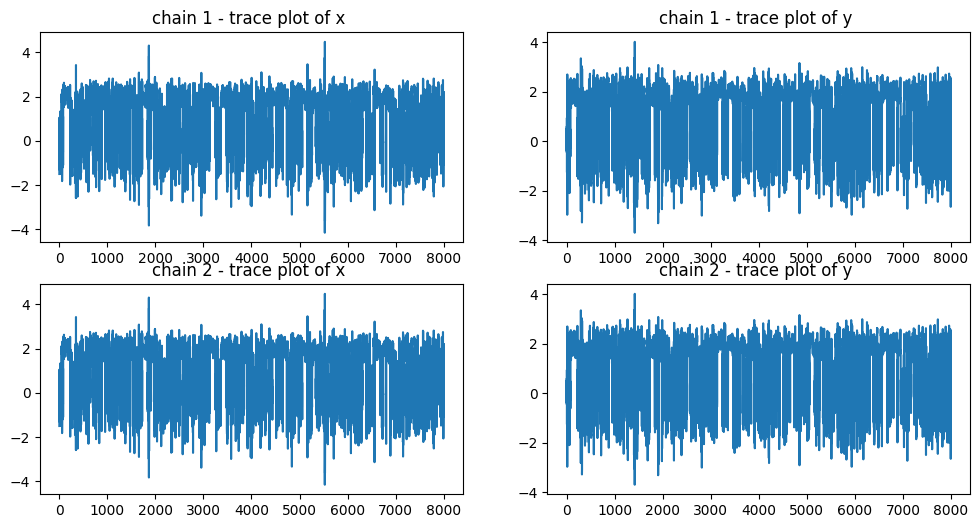

In [81]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot( np.arange(samples_1.shape[0]) ,samples_1[:, 0].detach().numpy())
plt.title("chain 1 - trace plot of x ")

plt.subplot(2,2,2)
plt.plot( np.arange(samples_1.shape[0]) ,samples_1[:, 1].detach().numpy())
plt.title("chain 1 - trace plot of y ")

plt.subplot(2,2,3)
plt.plot( np.arange(samples_2.shape[0]) ,samples_2[:, 0].detach().numpy())
plt.title("chain 2 - trace plot of x ")

plt.subplot(2,2,4)
plt.plot( np.arange(samples_2.shape[0]) ,samples_2[:, 1].detach().numpy())
plt.title("chain 2 - trace plot of y ")


### Gelman-Rubin statistic

In [82]:
def gelman_rubin_multivariate(chains):
    """
    Compute the Gelman-Rubin statistic for multiple chains in a multivariate distribution.

    Parameters:
    chains (list of numpy arrays): List of arrays representing different chains of multivariate samples.
    
    Returns:
    list of floats: List of Gelman-Rubin statistics (R-hat) for each dimension.
    """
    # Convert chains to numpy arrays
    chains = [np.asarray(chain) for chain in chains]

    # Number of chains and samples per chain
    num_chains = len(chains)
    num_samples = chains[0].shape[0]

    num_dimensions = chains[0].shape[1]

    r_hat_per_dimension = []

    for dimension in range(num_dimensions):
        # Extract samples for the current dimension from all chains
        dimension_samples = np.vstack([chain[:, dimension] for chain in chains])

        # Calculate the within-chain and between-chain variances for the dimension
        within_chain_var = np.mean([np.var(dimension_samples, ddof=1) for dimension_samples in chains])
        between_chain_var = np.var([np.mean(dimension_samples) for dimension_samples in chains], ddof=1)

        # Calculate the potential scale reduction factor (R-hat) for the dimension
        numerator = (num_samples - 1) / num_samples * within_chain_var + between_chain_var
        denominator = np.mean([np.var(dimension_samples, ddof=1) for dimension_samples in chains])
        r_hat = np.sqrt(numerator / denominator)
        r_hat_per_dimension.append(r_hat)

    return r_hat_per_dimension


r_hat_dimensions = gelman_rubin_multivariate([samples_1.detach().numpy(), samples_2.detach().numpy()])
for dimension, r_hat in enumerate(r_hat_dimensions):
    print(f"Dimension {dimension + 1}: Gelman-Rubin statistic (R-hat) = {r_hat}")


Dimension 1: Gelman-Rubin statistic (R-hat) = 0.9999374980467529
Dimension 2: Gelman-Rubin statistic (R-hat) = 0.9999374980467529
